# Calculate phase dependent modulation of AP threshold poisson excitation and rhythmic inhibition

The simulations had either: 
1. Rhythmic inhibition at the soma (64 Hz) or dendrites (16 Hz) 
2. Poisson excitation at the soma and dendrites

Here we calculate voltage threshold for action potentials. These are stratified by:
1. Phase (peak or trough) of the inhibitory rhythm
2. Frequency of rhythm

The output of this script are...


In [1]:
import sys
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.signal as ss
from src.bin_serser import bin_serser
from src.load_spike_h5 import load_spike_h5
from src.load_v_h5 import load_v_h5
from src.load_axcurrent_csv import load_axcurrent_csv

## 1.0 Analysis parameters


### 1.1 Simulation constants and analysis windows

In [2]:
samps_per_ms = 10 
edges_v = np.arange(-80,-40,0.5)
edges_i = np.linspace(-3,3,160)
sim_win = [0, 3000000] # beginning and start points of simulation in samples

In [3]:
# Determines which axial currents are valid
seg_df = pd.read_csv('Z:\\DendOscSub\\DetailedSegmentsAxialR.csv')
seg_df = seg_df[['segmentID', 'Type', 'ParentSegID']]
soma_ids = seg_df[seg_df['Type']=='soma'].segmentID.values
soma_conn = seg_df[np.isin(seg_df['ParentSegID'],soma_ids)]
soma_conn = soma_conn[(soma_conn['Type']=='dend') | (soma_conn['Type']=='apic')]
soma_conn['pairname'] = soma_conn['ParentSegID'].map(lambda x: f'{x:5.0f}'.lstrip()) + '_to_' + soma_conn['segmentID'].map(str)
basal_pairs = soma_conn['pairname'][soma_conn['Type']=='dend'].values
apic_pairs = soma_conn['pairname'][soma_conn['Type']=='apic'].values

### 1.2 List files to be processed

In [4]:
# locate simulation files
root_16_dir = 'Y:\\DendCompOsc\\output_burst_16Hz_dist\\'
sim_16_dict = {'SimName': 'burst_16hz_dist',
               'RootDir': root_16_dir,
               'CaFile': root_16_dir + 'output_burst_16Hz_dist_ca.csv',
               'NaFile': root_16_dir + 'output_burst_16Hz_dist_na.csv',
               'NMDAFile': root_16_dir + 'output_burst_16Hz_dist_nmda.csv',
               'APFile': root_16_dir + 'spikes.h5',
               'VMemFile': root_16_dir + 'v_report.h5',
               'ModFile': root_16_dir + 'modulatory_trace_16Hz.npy',}

root_64_dir = 'Y:\\DendCompOsc\\output_burst_64Hz_prox\\'
sim_64_dict = {'SimName': 'burst_64hz_prox',
               'RootDir': root_64_dir,
               'CaFile': root_64_dir + 'output_burst_64Hz_prox_ca.csv',
               'NaFile': root_64_dir + 'output_burst_64Hz_prox_na.csv',
               'NMDAFile': root_64_dir + 'output_burst_64Hz_prox_nmda.csv',
               'APFile': root_64_dir + 'spikes.h5',
               'VMemFile': root_64_dir + 'v_report.h5',
               'ModFile': root_64_dir + 'modulatory_trace_64Hz.npy'}


## 2.0 Phase binned probability of somatic spikes over membrane voltage

### 2.1 Generate phase series for each experiment

In [5]:
def burst_phase(sim_dict):
    """
    Calculates the phase of the modulatory trace at each point in the simulation
    Returns a series of the unwrapped phase of the modulatory trace, with NaNs for non-bursting periods
    
    Parameters
    ----------
    sim_dict : dict
        Dictionary containing the simulation name and file locations

    Returns
    -------
    burst_ph_ser : array
        Array of the unwrapped phase of the modulatory trace, with NaNs for non-bursting periods
    burst_ph_bins : array
        Array of the bin edges for the histogram of burst phase
    """

    # load the modulatory trace
    burst_mod = np.load(sim_dict['ModFile'])

    # identify points where the burst peaks occur
    # defined as the trough nearest to the peak in amplitude of the modulatory trace
    h_mod = ss.hilbert(burst_mod-np.mean(burst_mod))
    h_mod_amp = np.abs(h_mod)
    h_mod_phase = np.angle(h_mod)
    if sim_dict['SimName'] == 'burst_64hz_prox':
        amp_peaks = ss.find_peaks(h_mod_amp, distance=200, height=0.5)[0]
        osc_troughs = ss.find_peaks(-h_mod_phase, distance=10)[0]
    elif sim_dict['SimName'] == 'burst_16hz_dist':
        amp_peaks = ss.find_peaks(h_mod_amp, distance=500, height=0.5)[0]
        osc_troughs = ss.find_peaks(-h_mod_phase, distance=50)[0]

    # create a series of the unwrapped phase of the modulatory trace, with NaNs for non-bursting periods
    burst_ph_ser = np.ones(burst_mod.size)*np.nan
    for i, p in enumerate(amp_peaks):
        burst_mid = np.argmin(np.abs(osc_troughs-p))
        burst_start = osc_troughs[burst_mid-4]
        burst_end = osc_troughs[burst_mid+4]
        burst_ph_ser[burst_start:burst_end] = np.unwrap(h_mod_phase[burst_start:burst_end])

    burst_ph_ser = burst_ph_ser[:int(sim_win[1]/10)]
    burst_ph_bins = np.arange(-np.pi, (np.pi*2*8)-np.pi, np.pi/4)
    #plt.plot(burst_mod)
    #plt.scatter(osc_troughs, burst_mod[osc_troughs], c='r')
    #plt.scatter(amp_peaks, burst_mod[amp_peaks], c='g')
    return burst_ph_ser, burst_ph_bins

In [6]:
sim_16_dict['ModPhase'], sim_16_dict['ModBins'] = burst_phase(sim_16_dict)
sim_64_dict['ModPhase'], sim_64_dict['ModBins'] = burst_phase(sim_64_dict)

### 2.2 Calculate action potential threshold voltage

In [7]:
def mem_exc_func(sim_dict):
    mem_exc = {}

    # load action potentials
    spk_t = (load_spike_h5(sim_dict['APFile'])/samps_per_ms).astype(int)
    
    # load the modulatory trace
    burst_mod = np.load(sim_dict['ModFile'])

    # load soma voltage
    mem_v = load_v_h5(sim_dict['VMemFile'], 0)
    mem_v = mem_v[::samps_per_ms]

    # modulation by phase of rhythm
    mem_exc['mod_bin'] = bin_serser(burst_mod[:int(sim_win[1]/samps_per_ms)], sim_dict['ModPhase'],  sim_dict['ModBins'])

    # membrane voltage by phase of rhythm
    mem_exc['v_bin'] = bin_serser(mem_v, sim_dict['ModPhase'],  sim_dict['ModBins'])

    # membrane voltage and phase when action potentials occur
    mem_exc['v_ph_spk'] = np.vstack((mem_v[spk_t-1], sim_dict['ModPhase'][spk_t-1]))

    return mem_exc

In [8]:
mem_exc_16 = mem_exc_func(sim_16_dict)
mem_exc_64 = mem_exc_func(sim_64_dict)

c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


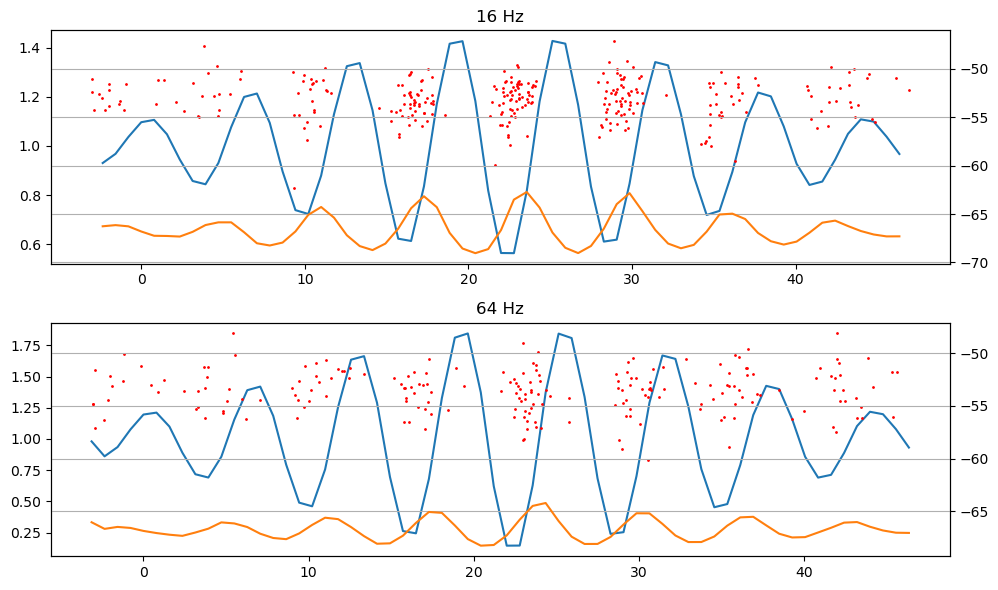

In [9]:
def plot_mem_exc(mem_exc, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.plot(mem_exc['mod_bin']['edges'], mem_exc['mod_bin']['values'])
    ax_t = ax.twinx()
    ax_t.plot(mem_exc['v_bin']['edges'], mem_exc['v_bin']['values'],'tab:orange')
    ax_t.grid()
    ax_t.scatter(mem_exc['v_ph_spk'][1], mem_exc['v_ph_spk'][0], c='r', s=1)

fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_mem_exc(mem_exc_16, ax[0])
plot_mem_exc(mem_exc_64, ax[1])
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.tight_layout()

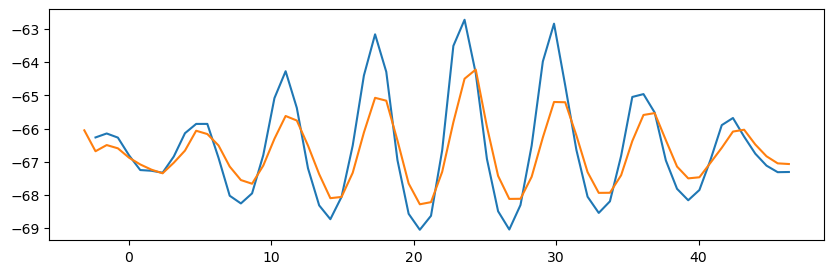

In [10]:
plt.figure(figsize=(10,3))
plt.plot(mem_exc_16['v_bin']['edges'], mem_exc_16['v_bin']['values'])
plt.plot(mem_exc_64['v_bin']['edges'], mem_exc_64['v_bin']['values'])

In [11]:
# process the 16 Hz distal dendritic inhibition simulation
ph16_prob = thresh_files_func(sim_16_dict, sin_16_ser)

# process the 64 Hz proximal dendritic/somatic inhibition simulation
ph64_prob = thresh_files_func(sim_64_dict, sin_64_ser)

# process the poisson inhibition simulation
pois_prob = thresh_files_pois_func(sim_pois_dict)

NameError: name 'thresh_files_func' is not defined

### 2.3 Plots

In [ ]:
# plotting functions
# set meas to 'v' for voltage, and 'i' for current
def ap_prob_ph_plot(ph_prob, ax, meas='v'):
        if meas=='v':
                edges = edges_v[:-1]
        elif meas=='i_apic' or meas=='i_basal':
                edges = edges_i[:-1]
        
        ax.plot(edges, ph_prob[meas]['p']['prob']/np.max(ph_prob[meas]['p']['prob']),color='r')
        ax.plot(edges, ph_prob[meas]['t']['prob']/np.max(ph_prob[meas]['t']['prob']),color='b')
        ax.plot(edges, pois_prob[meas]['pois']['prob']/np.max(pois_prob[meas]['pois']['prob']),color='k')

def meas_prob_ph_plot(ph_prob, ax, meas='v'):
        if meas=='v':
                edges = edges_v[:-1]
        elif meas=='i_apic' or meas=='i_basal':
                edges = edges_i[:-1]

        ax.plot(edges, ph_prob[meas]['p']['dist']/np.max(ph_prob[meas]['p']['dist']),color='r')
        ax.plot(edges, ph_prob[meas]['t']['dist']/np.max(ph_prob[meas]['t']['dist']),color='b')
        ax.plot(edges, pois_prob[meas]['pois']['dist']/np.max(pois_prob[meas]['pois']['dist']),color='k')

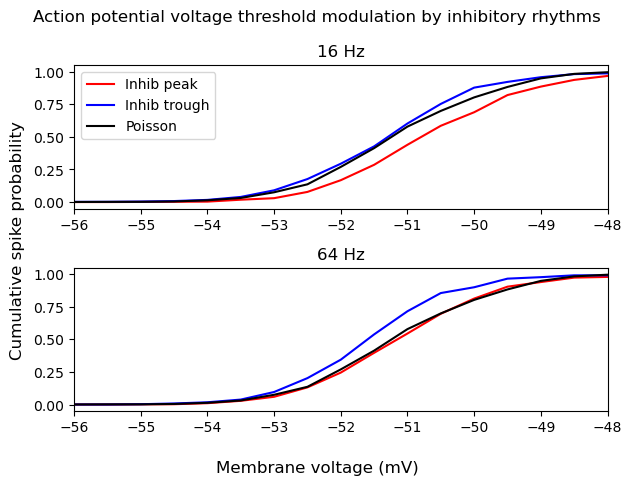

In [ ]:
# Action potential probabilities by membrane voltage and phase
fig, ax = plt.subplots(2,1,sharey=True)
ap_prob_ph_plot(ph16_prob, ax[0])
ap_prob_ph_plot(ph64_prob, ax[1])
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
ax[0].set_xlim([-56, -48])
ax[1].set_xlim([-56, -48])
fig.suptitle('Action potential voltage threshold modulation by inhibitory rhythms')
fig.supxlabel('Membrane voltage (mV)')
fig.supylabel('Cumulative spike probability')
ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
plt.tight_layout()
plt.savefig('../figures/APVoltDependence.png')


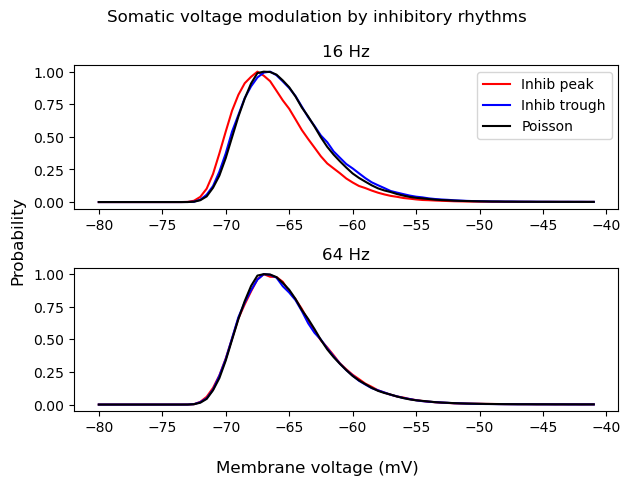

In [ ]:
# Membrane voltage by phase
fig, ax = plt.subplots(2,1,sharey=True)
meas_prob_ph_plot(ph16_prob, ax[0])
meas_prob_ph_plot(ph64_prob, ax[1])
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Somatic voltage modulation by inhibitory rhythms')
fig.supxlabel('Membrane voltage (mV)')
fig.supylabel('Probability')
ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
plt.tight_layout()
plt.show()

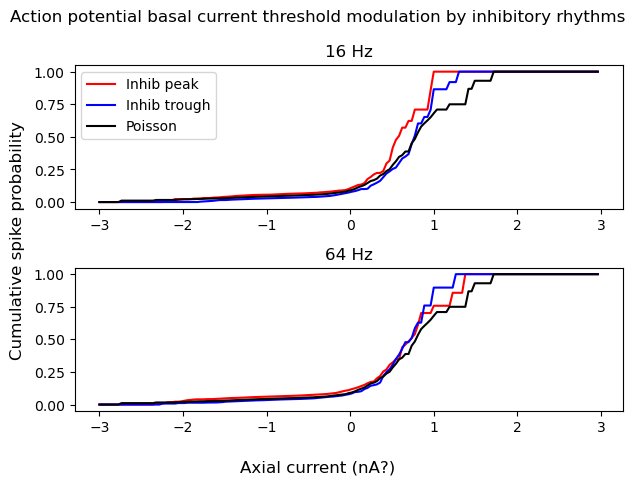

In [ ]:
# Action potential probabilities by basal dendrite axial current and phase
fig, ax = plt.subplots(2,1,sharey=True)
ap_prob_ph_plot(ph16_prob, ax[0], meas='i_basal')
ap_prob_ph_plot(ph64_prob, ax[1], meas='i_basal')
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Action potential basal current threshold modulation by inhibitory rhythms')
fig.supxlabel('Axial current (nA?)')
fig.supylabel('Cumulative spike probability')
ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
plt.tight_layout()
plt.show()

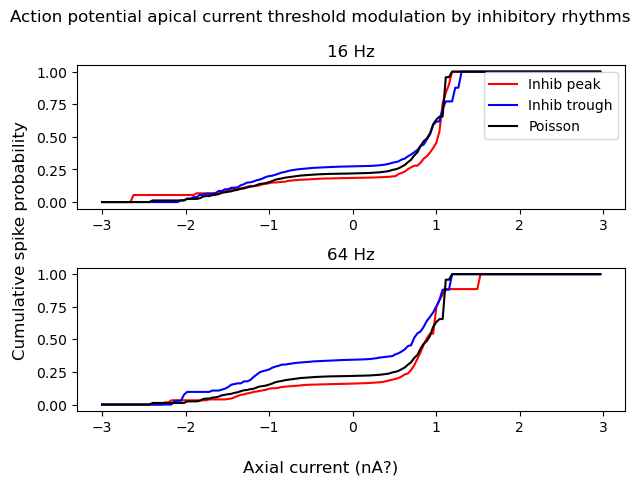

In [ ]:
# Action potential probabilities by apical dendrite axial current and phase
fig, ax = plt.subplots(2,1,sharey=True)
ap_prob_ph_plot(ph16_prob, ax[0], meas='i_apic')
ap_prob_ph_plot(ph64_prob, ax[1], meas='i_apic')
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Action potential apical current threshold modulation by inhibitory rhythms')
fig.supxlabel('Axial current (nA?)')
fig.supylabel('Cumulative spike probability')
ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
plt.tight_layout()
plt.savefig('../figures/APAxialApicDepend.png')

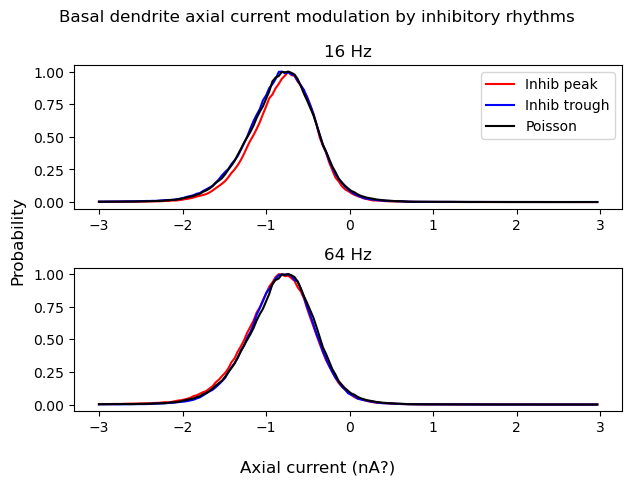

In [ ]:
# Basal dendrite axial current modulation by phase
fig, ax = plt.subplots(2,1,sharey=True)
meas_prob_ph_plot(ph16_prob, ax[0], meas='i_basal')
meas_prob_ph_plot(ph64_prob, ax[1], meas='i_basal')
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Basal dendrite axial current modulation by inhibitory rhythms')
fig.supxlabel('Axial current (nA?)')
fig.supylabel('Probability')
ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
plt.tight_layout()
plt.show()

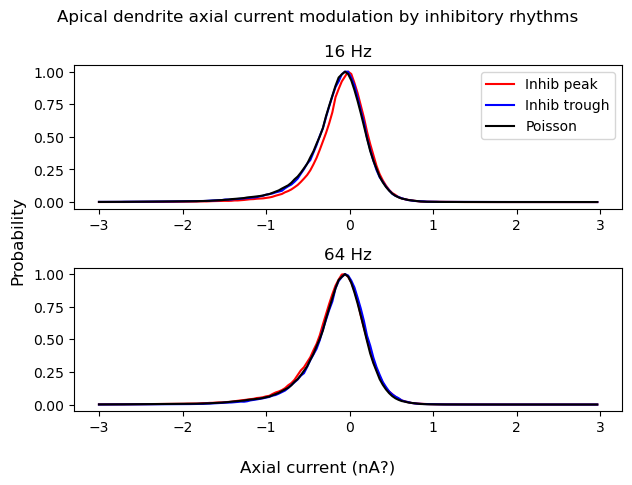

In [ ]:
# Apical dendrite axial current modulation by phase
fig, ax = plt.subplots(2,1,sharey=True)
meas_prob_ph_plot(ph16_prob, ax[0], meas='i_apic')
meas_prob_ph_plot(ph64_prob, ax[1], meas='i_apic')
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Apical dendrite axial current modulation by inhibitory rhythms')
fig.supxlabel('Axial current (nA?)')
fig.supylabel('Probability')
ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
plt.tight_layout()
plt.show()